In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv1 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'images_reduced'

# Ground truth
#train_labels_filename = preprocess_path + '/cic_train_reduced.csv'
train_labels_filename = preprocess_path + '/cic_train_val_reduced.csv'
val_labels_filename   = preprocess_path + '/cic_val_reduced.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 45/45 [00:00<00:00, 166.12it/s]
Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 400:
        return 0.001
    else:
        return 0.0001

In [10]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv1/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 129s 646ms/step - loss: 119.5895 - val_loss: 107.5510
Number of images: 1025
Presicion: 0.012
Recall: 0.1561
F1 score: 0.0223
F1 score: 0.022255618821040844
Improve F1 score from -inf to 0.022255618821040844
Epoch 2/100
200/200 [==============================] - 112s 559ms/step - loss: 107.4597 - val_loss: 106.7861
Number of images: 1025
Presicion: 0.014
Recall: 0.178
F1 score: 0.0259
F1 score: 0.025949110973929528
Improve F1 score from 0.022255618821040844 to 0.025949110973929528
Epoch 3/100
200/200 [==============================] - 113s 567ms/step - loss: 110.2785 - val_loss: 526226.5110


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] -

Number of images: 1025
Presicion: 0.0002
Recall: 0.0058
F1 score: 0.0004
F1 score: 0.0004355285849459122
Epoch 4/100
200/200 [==============================] - 114s 570ms/step - loss: 108.8831 - val_loss: 123.8342
Number of images: 1025
Presicion: 0.0247
Recall: 0.2375
F1 score: 0.0447
F1 score: 0.04470209956532777
Improve F1 score from 0.025949110973929528 to 0.04470209956532777
Epoch 5/100
200/200 [==============================] - 111s 557ms/step - loss: 109.3710 - val_loss: 137.2526
Number of images: 1025
Presicion: 0.0086
Recall: 0.1738
F1 score: 0.0165
F1 score: 0.016472913716781102
Epoch 6/100
200/200 [==============================] - 108s 538ms/step - loss: 85.1231 - val_loss: 1297575.5532
Number of images: 1025
Presicion: 0.0243
Recall: 0.099
F1 score: 0.039
F1 score: 0.039018634988945505
Epoch 7/100
200/200 [==============================] - 107s 533ms/step - loss: 36.6497 - val_loss: 1632.7361
Number of images: 1025
Presicion: 0.1261
Recall: 0.3251
F1 score: 0.1817
F1 score

Number of images: 1025
Presicion: 0.0399
Recall: 0.3282
F1 score: 0.0712
F1 score: 0.07120879861164414
Epoch 42/100
200/200 [==============================] - 108s 539ms/step - loss: 114.8885 - val_loss: 114.0511
Number of images: 1025
Presicion: 0.0725
Recall: 0.4314
F1 score: 0.1242
F1 score: 0.12417522571742816
Epoch 43/100
200/200 [==============================] - 109s 543ms/step - loss: 114.7552 - val_loss: 114.1446
Number of images: 1025
Presicion: 0.0431
Recall: 0.3291
F1 score: 0.0762
F1 score: 0.07624126277674372
Epoch 44/100
200/200 [==============================] - 108s 541ms/step - loss: 94.5087 - val_loss: 24.7686
Number of images: 1025
Presicion: 0.1333
Recall: 0.3165
F1 score: 0.1876
F1 score: 0.18758850703924468
Epoch 45/100
200/200 [==============================] - 108s 542ms/step - loss: 23.2906 - val_loss: 121.6824
Number of images: 1025
Presicion: 0.0507
Recall: 0.3604
F1 score: 0.0888
F1 score: 0.08883109959938425
Epoch 46/100
200/200 [==========================

200/200 [==============================] - 107s 533ms/step - loss: 4.4921 - val_loss: 4.5352
Number of images: 1025
Presicion: 0.0662
Recall: 0.5264
F1 score: 0.1176
F1 score: 0.11756536239827146
Epoch 19/100
200/200 [==============================] - 106s 531ms/step - loss: 4.4473 - val_loss: 4.4742
Number of images: 1025
Presicion: 0.0656
Recall: 0.5321
F1 score: 0.1168
F1 score: 0.11675263412670212
Epoch 20/100
200/200 [==============================] - 107s 535ms/step - loss: 4.4789 - val_loss: 4.6191
Number of images: 1025
Presicion: 0.0502
Recall: 0.5173
F1 score: 0.0915
F1 score: 0.09145362704492006
Epoch 21/100
200/200 [==============================] - 107s 535ms/step - loss: 4.4418 - val_loss: 4.4411
Number of images: 1025
Presicion: 0.0582
Recall: 0.5333
F1 score: 0.1049
F1 score: 0.10491757169059956
Epoch 22/100
200/200 [==============================] - 107s 533ms/step - loss: 4.3622 - val_loss: 4.3829
Number of images: 1025
Presicion: 0.0673
Recall: 0.5378
F1 score: 0.119

200/200 [==============================] - 108s 539ms/step - loss: 3.9413 - val_loss: 4.1049
Number of images: 1025
Presicion: 0.106
Recall: 0.5173
F1 score: 0.1759
F1 score: 0.1759269984678181
Epoch 96/100
200/200 [==============================] - 108s 538ms/step - loss: 3.9124 - val_loss: 4.0116
Number of images: 1025
Presicion: 0.0784
Recall: 0.5322
F1 score: 0.1367
F1 score: 0.13669439213398524
Epoch 97/100
200/200 [==============================] - 107s 537ms/step - loss: 4.0264 - val_loss: 4.2589
Number of images: 1025
Presicion: 0.0341
Recall: 0.5378
F1 score: 0.0641
F1 score: 0.06405410054799278
Epoch 98/100
200/200 [==============================] - 106s 530ms/step - loss: 3.9406 - val_loss: 4.0997
Number of images: 1025
Presicion: 0.1867
Recall: 0.4594
F1 score: 0.2655
F1 score: 0.26554925570419996
Improve F1 score from 0.23947811879701766 to 0.26554925570419996
Epoch 99/100
200/200 [==============================] - 109s 544ms/step - loss: 3.9502 - val_loss: 3.9374
Number o

200/200 [==============================] - 107s 533ms/step - loss: 4.5386 - val_loss: 4.5765
Number of images: 1025
Presicion: 0.1166
Recall: 0.4848
F1 score: 0.188
F1 score: 0.18796212153044697
Epoch 34/100
200/200 [==============================] - 107s 533ms/step - loss: 4.5275 - val_loss: 4.5805
Number of images: 1025
Presicion: 0.1028
Recall: 0.4834
F1 score: 0.1695
F1 score: 0.16947958185209708
Epoch 35/100
200/200 [==============================] - 107s 533ms/step - loss: 4.5306 - val_loss: 4.5827
Number of images: 1025
Presicion: 0.1019
Recall: 0.4901
F1 score: 0.1688
F1 score: 0.16877009991826136
Epoch 36/100
200/200 [==============================] - 108s 538ms/step - loss: 4.4782 - val_loss: 4.5528
Number of images: 1025
Presicion: 0.1201
Recall: 0.4631
F1 score: 0.1908
F1 score: 0.19076676256578043
Epoch 37/100
200/200 [==============================] - 107s 533ms/step - loss: 4.4885 - val_loss: 4.5146
Number of images: 1025
Presicion: 0.1154
Recall: 0.488
F1 score: 0.1866


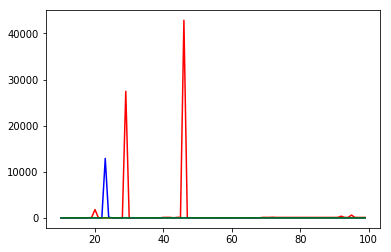

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

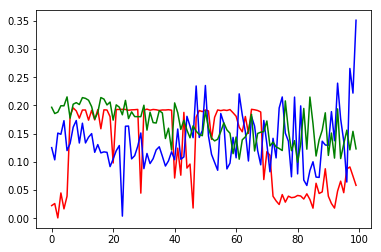

In [12]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v1_factor_1.5.h5')
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/CIC/shufflenet_v1_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 500
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/CIC/shufflenet_v1_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/500

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 21s 1s/step - loss: 3.9480
Epoch 2/500

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 650ms/step - loss: 3.9532
Epoch 3/500

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 735ms/step - loss: 3.7168
Epoch 4/500

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 761ms/step - loss: 3.7801
Epoch 5/500

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 783ms/step - loss: 3.6053
Epoch 6/500

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 751ms/step - loss: 3.6982
Epoch 7/500

Epoch 00007: LearningRateScheduler setting learning 

15/15 [==============================] - 11s 704ms/step - loss: 2.9158
Epoch 55/500

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 655ms/step - loss: 2.8998
Epoch 56/500

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 693ms/step - loss: 2.8162
Epoch 57/500

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 699ms/step - loss: 2.8444
Epoch 58/500

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 704ms/step - loss: 2.7948
Epoch 59/500

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 2.9245
Epoch 60/500

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 695ms/step - loss: 2.8277
Epoch 61/500

Epo

15/15 [==============================] - 11s 705ms/step - loss: 2.6052
Epoch 109/500

Epoch 00109: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 721ms/step - loss: 2.5923
Epoch 110/500

Epoch 00110: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 731ms/step - loss: 2.5923
Epoch 111/500

Epoch 00111: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 706ms/step - loss: 2.5455
Epoch 112/500

Epoch 00112: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 722ms/step - loss: 2.5321
Epoch 113/500

Epoch 00113: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 715ms/step - loss: 2.5629
Epoch 114/500

Epoch 00114: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 721ms/step - loss: 2.6619
Epoch 115/5

15/15 [==============================] - 11s 710ms/step - loss: 2.4865
Epoch 163/500

Epoch 00163: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 692ms/step - loss: 2.3862
Epoch 164/500

Epoch 00164: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 706ms/step - loss: 2.4389
Epoch 165/500

Epoch 00165: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 676ms/step - loss: 2.4103
Epoch 166/500

Epoch 00166: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 735ms/step - loss: 2.3965
Epoch 167/500

Epoch 00167: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 688ms/step - loss: 2.3935
Epoch 168/500

Epoch 00168: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 696ms/step - loss: 2.4800
Epoch 169/5

15/15 [==============================] - 11s 704ms/step - loss: 2.1915
Epoch 217/500

Epoch 00217: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 679ms/step - loss: 2.2657
Epoch 218/500

Epoch 00218: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 2.3868
Epoch 219/500

Epoch 00219: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 698ms/step - loss: 2.2837
Epoch 220/500

Epoch 00220: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 718ms/step - loss: 2.3973
Epoch 221/500

Epoch 00221: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 2.3405
Epoch 222/500

Epoch 00222: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 693ms/step - loss: 2.3750
Epoch 223/5

15/15 [==============================] - 11s 703ms/step - loss: 2.1918
Epoch 271/500

Epoch 00271: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 708ms/step - loss: 2.2861
Epoch 272/500

Epoch 00272: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 708ms/step - loss: 2.3019
Epoch 273/500

Epoch 00273: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 713ms/step - loss: 2.1911
Epoch 274/500

Epoch 00274: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 727ms/step - loss: 2.2391
Epoch 275/500

Epoch 00275: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 694ms/step - loss: 2.1206
Epoch 276/500

Epoch 00276: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 728ms/step - loss: 2.2504
Epoch 277/5

15/15 [==============================] - 10s 695ms/step - loss: 2.1118
Epoch 325/500

Epoch 00325: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 683ms/step - loss: 2.1330
Epoch 326/500

Epoch 00326: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 705ms/step - loss: 2.2854
Epoch 327/500

Epoch 00327: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 698ms/step - loss: 2.0988
Epoch 328/500

Epoch 00328: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 710ms/step - loss: 2.1346
Epoch 329/500

Epoch 00329: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 725ms/step - loss: 2.2266
Epoch 330/500

Epoch 00330: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 717ms/step - loss: 2.1713
Epoch 331/5

15/15 [==============================] - 10s 698ms/step - loss: 2.1684
Epoch 379/500

Epoch 00379: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 705ms/step - loss: 2.1285
Epoch 380/500

Epoch 00380: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 708ms/step - loss: 2.0415
Epoch 381/500

Epoch 00381: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 711ms/step - loss: 2.1940
Epoch 382/500

Epoch 00382: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 690ms/step - loss: 1.9843
Epoch 383/500

Epoch 00383: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 700ms/step - loss: 2.1131
Epoch 384/500

Epoch 00384: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 728ms/step - loss: 2.0488
Epoch 385/5

15/15 [==============================] - 11s 749ms/step - loss: 1.9152
Epoch 432/500

Epoch 00432: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 706ms/step - loss: 1.8022
Epoch 433/500

Epoch 00433: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 703ms/step - loss: 1.8036
Epoch 434/500

Epoch 00434: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 724ms/step - loss: 2.0042
Epoch 435/500

Epoch 00435: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 693ms/step - loss: 1.8015
Epoch 436/500

Epoch 00436: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 704ms/step - loss: 1.9529
Epoch 437/500

Epoch 00437: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 727ms/step - loss: 1.9617
Epoch

15/15 [==============================] - 11s 759ms/step - loss: 1.7522
Epoch 485/500

Epoch 00485: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 746ms/step - loss: 1.9290
Epoch 486/500

Epoch 00486: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 775ms/step - loss: 1.9147
Epoch 487/500

Epoch 00487: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 725ms/step - loss: 1.8412
Epoch 488/500

Epoch 00488: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 742ms/step - loss: 1.8537
Epoch 489/500

Epoch 00489: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 765ms/step - loss: 1.9393
Epoch 490/500

Epoch 00490: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 758ms/step - loss: 1.8582
Epoch